# Classificação de imagens industriais entre normais e com defeito

Este projeto realiza modelagem de uma rede neural de aprendizado supervisionado que inspeciona as imagens de produtos industriais e classifica entre normais e com defeitos. Possibilitando a automatização da inspeção da linha de produção, evitando que produtos com defeitos cheguem aos consumidores finais.

O dataset utilizado neste projeto é o [MVTecAD](https://www.mvtec.com/company/research/datasets/mvtec-ad). Este dataset contém imagens de 15 produtos diferentes com imagens normais no conjunto de treinamento e imagens normais e com defeitos no conjunto de teste. Para lidar com esse problema de maneira supervisionada, iremos concatenar os conjuntos de treinamento e teste, e realizar uma nova divisão. Por questão de demonstração, neste projeto é utilizado somente a cápsula.

In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.applications.resnet_v2 import preprocess_input

## Carregamento do dataset

Este dataset está dividido em pastas que dividem entre conjunto de treinamento e teste, e pastas que identificam a classe da imagem. Abaixo é definido um método para realizar o carregamento das imagens, retornando as imagens e suas classes.

In [70]:
def load_images(folder_path):
    """
    Carrega imagens em um diretório e em suas subpastas, atribui rótulo 1 para normais e 0 para anomalias e converte para um numpy.array.

    Args:
        folder_path: string representando o caminho da pasta.

    Returns:
        images: numpy.array contendo todas as imagens da pasta.
        y: numpy.array contendo as labels das imagens
    """
    images = []
    y = []
    for root, direc, files in os.walk(folder_path): # percorre todas as pastas e subpastas procurando por arquivos
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = imageio.imread(file_path)
                    images.append(img)
                    #Aplica rotulo as imagens 0==normal / 1 == defeito
                    if os.path.split(root)[1] == 'good':
                        y.append(0)
                    else:
                        y.append(1)
                except Exception as e:
                    print(f'Não foi possível abrir a imagem {file_path}: {e}')

    images = np.stack(images)
    y = np.stack(y)

    return images, y

A divisão original do dataset contém somente imagens da classe normal no conjunto de treinamento. Como neste projeto será utilizado um modelo de classificação onde o treinamento é realizado com exemplos de todas as classes, os conjuntos de treino e teste devem ser mesclados para que contenham exemplos das duas classes. Para isso foi utilizado o seguinte método:

In [71]:
def mescla_dataset(img_train, img_test, y_train, y_test):
    """
    Concatena os datasets de treino e teste, e separa em imagens e rótulos

    Args:
        img_train: numpyarray das imagens de treinamento
        img_test: numpyarray das imagens de teste
        y_train: rótulos das imagens de treinamento
        y_test: rótulos das imagens de teste

    Returns:
        X: numpyarray com as imagens concatenadas
        y: numpyarray com os rótulos concatenadas
    """

    X = np.vstack((img_train, img_test)) #concatena imagens treino e teste
    y = np.concatenate((y_train, y_test), axis=0)

    return X, y

In [72]:
# Carrega os dados de treinamento e teste para o objeto cápsula
X_train_capsule, y_train_capsule = load_images('/kaggle/input/mvtec-ad/capsule/train')
X_test_capsule, y_test_capsule = load_images('/kaggle/input/mvtec-ad/capsule/test')

# Mescla conjunto de treinamento e teste
X_capsule, y_capsule = mescla_dataset(X_train_capsule, X_test_capsule, y_train_capsule, y_test_capsule)

Agora que os conjuntos de treino e teste foram mesclados é necessário realizar a nova divisão

In [73]:
# divisão entre treino e teste
X_train_capsule, X_test_capsule, y_train_capsule, y_test_capsule = train_test_split(X_capsule, y_capsule,
                                                                                     train_size=0.8, 
                                                                                     stratify= y_capsule,
                                                                                     random_state=2)
# separação de parte do treinamento para validação
X_train_capsule, X_val_capsule, y_train_capsule, y_val_capsule = train_test_split(X_train_capsule, y_train_capsule,
                                                                                     train_size=0.8, 
                                                                                     stratify= y_train_capsule, 
                                                                                     random_state= 2)

## Análise do dataset

Para conhecermos o dataset vamos exibir algumas imagens e verificar suas características. Além de verificar quantas instâncias temos disponíveis para cada classe.

In [74]:
def show_images(images, labels, n_img):
    """
    Mostra uma sequência de imagens com seus respectivos rótulos.
    As imagens são escolhidas aleatóriamente do conjunto passado por parâmetro.

    Args:
        images : array-like Conjunto de imagens a serem exibidas.
        labels : array-like Lista de rótulos correspondentes às imagens.
        n_img : int Número de imagens a serem exibidas.
    """

    fig, ax = plt.subplots(n_img, 1, figsize=(10,(5 * n_img)))
    for i in range(n_img):
        idx = np.random.randint(0, len(labels))
        if labels[idx]:
            ax[i].set_title('Rótulo: Defeito')
        else:
            ax[i].set_title('Rótulo: Normal')
        ax[i].imshow(images[idx])
        ax[i].axis('off')

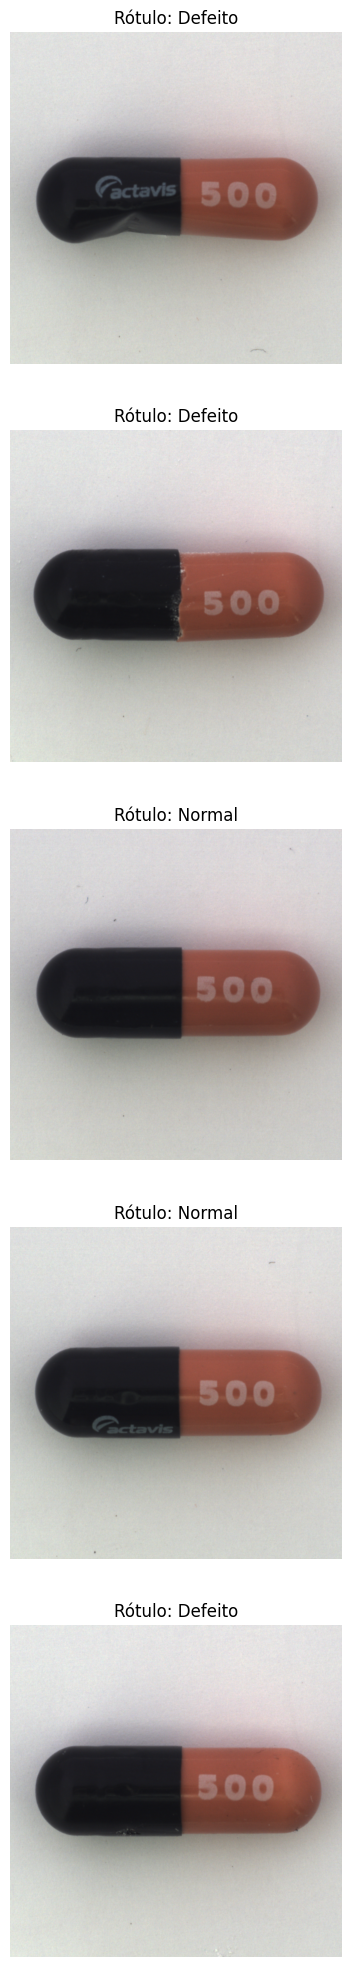

In [88]:
show_images(X_test_capsule, y_test_capsule, n_img= 5)

Ao analisarmos as imagens desse objeto podemos observar que elas foram capturadas na mesma posição, mas com algumas alterações na posição da escrita no objeto, e os defeitos são de diferentes tipos, podendo ser bem sutis.

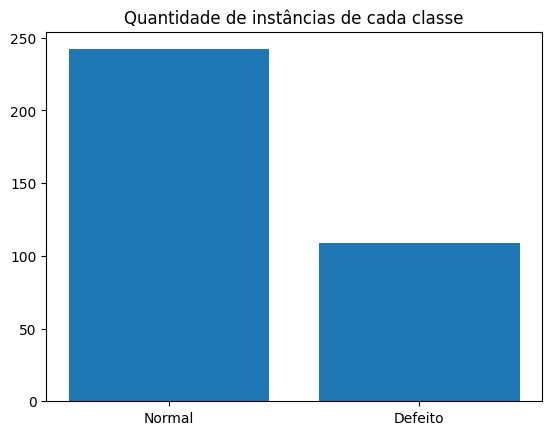

Total de imagens:  351
Quantidade imagens com defeito:  109
Quantidade imagens normais:  242


In [76]:
count_classes = np.unique(y_capsule, return_counts=True)
plt.bar(x=['Normal', 'Defeito'], height=count_classes[1])
plt.title('Quantidade de instâncias de cada classe')
plt.show();
print('Total de imagens: ', y_capsule.shape[0])
print('Quantidade imagens com defeito: ', count_classes[1][1])
print('Quantidade imagens normais: ', count_classes[1][0])

Pode-se notar que há poucas imagens no conjunto e com grande desbalanceamento entre as classes, tendo muito menos instâncias da classe defeito, característica esperada em uma situação real nesse tipo de problema.

## Modelagem

O seguinte método faz a criação de uma rede neural ResNet50V2 pré-treinada no dataset ImageNet, sendo adicionada uma nova camada de saída e possibilita o descongelamento das camadas finais para habilitar o treinamento delas.

In [77]:
def create_model(shape, augmentation=None, last_layers_unfreeze=None):
    """
    Cria um modelo de rede neural baseado na arquitetura ResNet50V2 para classificação binária.
    Permitindo o descongelamento das camadas finais para habilitar o treinamento.

    Args:
        shape : tuple representando o formato da entrada da imagem
        augmentation : tf.keras.Sequential camadas de transformações para o aumento de dados
        last_layers_unfreeze : int número de últimas camadas a serem descongeladas

    Returns:
        model : tf.keras.Model modelo construído com a base da ResNet50V2
    """

    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=shape)
    if augmentation is not None:
        inputs = augmentation(inputs)
    preprocess = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    x = base_model(preprocess, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, output)

    if last_layers_unfreeze is not None:
        model.layers[-1].trainable = True
        print('Layer unfreezed: ', model.layers[-1])
        model.layers[-2].trainable = True
        print('Layer unfreezed: ', model.layers[-2])

        for layer in base_model.layers[-(last_layers_unfreeze-2):]:
            layer.trainable = True
            print('Layer unfreezed: ', layer)
    return model

### Aumento de dados

Como o dataset tem poucas imagens serão aplicadas transformações nas imagens para trazer maior diversidade ao conjunto de treinamento, com intuito de melhorar a capacidade de generalização do modelo. 
Para que esse aumento de dados seja efetivo é importante que as transformações não alterem características importantes na separação das classes e que não altere a classe original da imagem.
Para escolher quais transformações e em quais intensidades serão aplicadas vamos realizar uma analise visual.

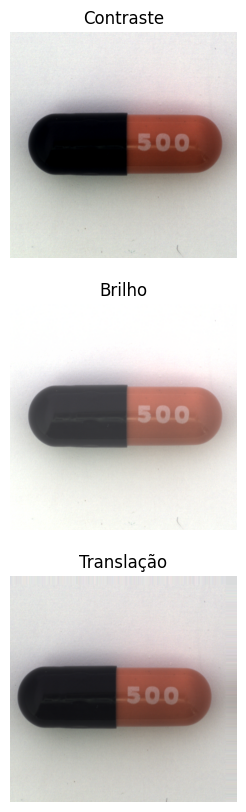

In [83]:
img = tf.image.convert_image_dtype(X_train_capsule[0], tf.float32)
img = tf.expand_dims(img, axis=0)

fig, ax = plt.subplots(3,1, figsize=(20,10))
contraste = tf.keras.layers.RandomContrast(factor= 0.5)(img)
ax[0].set_title('Contraste')
ax[0].imshow(contraste[0])
ax[0].axis('off')

brilho = tf.keras.layers.RandomBrightness(factor= (0.1, 0.2), value_range=(0.0, 1.0))(img)
ax[1].set_title('Brilho')
ax[1].imshow(brilho[0])
ax[1].axis('off')

translacao = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.05, fill_mode='nearest')(img)
ax[2].set_title('Translação')
ax[2].imshow(translacao[0])
ax[2].axis('off');

Essas transformações exibidas parecem manter as principais características da imagem e sua classe, sendo assim, elas serão aplicadas randomicamente as imagens durante o treinamento.

In [79]:
data_augmentation_capsule = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor= 0.5, seed=2),
  tf.keras.layers.RandomBrightness(factor= (0.1, 0.2), seed=2),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.05, fill_mode='nearest', seed=2)
])

### Treinamento da rede

O treinamento da rede utilizará de algumas técnicas buscando a melhora na performance do modelo:
- Class_weights: com pesos maiores para a classe defeito que está em minoria no dataset
- Learning rate decay: para diminuir o learning rate conforme o treinamento avança, evitando muitas oscilações
- Early stopping: monitora a loss de validação para interromper o treinamento quando não houver mais melhorias, evitando assim o overfitting

In [80]:
BATCH_SIZE = 32
EPOCHS_DECAY = 5

class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(y_train_capsule), 
                                     y=y_train_capsule)
dict_class_weights = {0:class_weights[0], 1:class_weights[1]}

model_capsule = create_model(shape= (1000,1000,3), 
                             augmentation=data_augmentation_capsule, 
                             last_layers_unfreeze=6)

decay_step = (np.ceil(y_train_capsule.shape[0]/BATCH_SIZE) * EPOCHS_DECAY)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=0.01, 
                                decay_steps= decay_step, 
                                decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=0.01, 
                                            patience=5,
                                            restore_best_weights=True)
model_capsule.compile(optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
history_capsule = model_capsule.fit(X_train_capsule,
                                    y_train_capsule, 
                                    epochs = 100, 
                                    callbacks= [callback], 
                                    validation_data=(X_val_capsule, y_val_capsule),
                                    class_weight= dict_class_weights,
                                    batch_size=BATCH_SIZE)

Layer unfreezed:  <Dense name=dense_5, built=True>
Layer unfreezed:  <GlobalAveragePooling2D name=global_average_pooling2d_5, built=True>
Layer unfreezed:  <Conv2D name=conv5_block3_3_conv, built=True>
Layer unfreezed:  <Add name=conv5_block3_out, built=True>
Layer unfreezed:  <BatchNormalization name=post_bn, built=True>
Layer unfreezed:  <Activation name=post_relu, built=True>
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4338 - loss: 1.4606 - val_accuracy: 0.3036 - val_loss: 45.8439
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6855 - loss: 0.9552 - val_accuracy: 0.3036 - val_loss: 78.3994
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6478 - loss: 0.4887 - val_accuracy: 0.3036 - val_loss: 10.9114
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8659 - loss: 0.4058 - val_accuracy: 0.3036 - val_loss: 24.4562
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8550 - loss: 0.2750 - val_accuracy: 0.3036 - val_lo

## Avaliação
Para avaliar o modelo será utilizado várias métricas como a acurácia balanceada, já que ela considera o fato do dataset ser desbalanceado e métricas como a precisão e revocação, além de analisar a matriz de confusão.

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98        49
     Defeito       1.00      0.91      0.95        22

    accuracy                           0.97        71
   macro avg       0.98      0.95      0.97        71
weighted avg       0.97      0.97      0.97        71

Acurácia balanceada:  0.9545454545454546


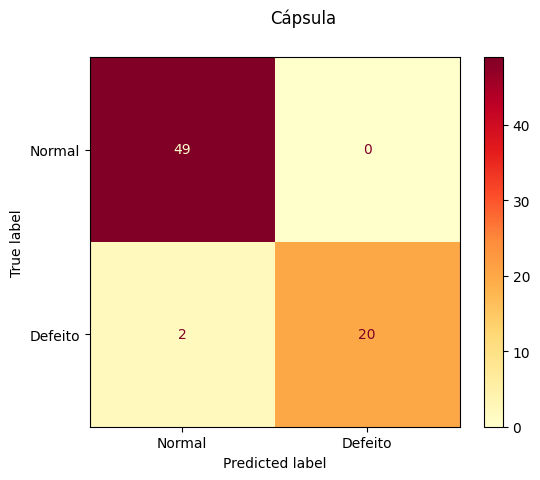

In [81]:
y_pred_capsule = model_capsule.predict(X_test_capsule)
y_pred_capsule = np.where(y_pred_capsule < 0.5, 0, 1)
print(classification_report(y_test_capsule, y_pred_capsule, target_names=['Normal', 'Defeito']))
print("Acurácia balanceada: ", balanced_accuracy_score(y_test_capsule, y_pred_capsule))
disp1 = ConfusionMatrixDisplay.from_predictions(y_test_capsule, y_pred_capsule, cmap='YlOrRd', display_labels=['Normal', 'Defeito']);
disp1.figure_.suptitle("Cápsula");

O modelo conseguiu classificar corretamente todas as instâncias normais e errou somente 2 instâncias da classe defeito, como mostra a matriz de confusão, obtendo assim, uma acurácia balanceada de 95,4%, mostrando que mesmo o dataset sendo desbalanceado e com poucas imagens o modelo conseguiu obter uma boa performance.